# OpenAP - Estimation Fuel and Emissions

## Install OpenAP


In [1]:
%pip install OpenAP
%pip install cartopy

/home/junzi/env/openap-v3/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/home/junzi/env/openap-v3/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


Import packages

In [2]:
import openap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
flight = pd.read_csv(
    "https://github.com/junzis/tutorial-icrat24-openap/raw/master/data/flight_a320.csv"
)

In [4]:
flight.head()

,time,altitude,groundspeed,true_airspeed,vertical_rate,mass,fuel_flow
0,527.0,60.453125,31.777344,31.777344,0.0,69762.525139,2.131332
1,528.0,64.000000,36.777344,36.777344,0.0,69762.525139,2.105302
2,529.0,64.453125,41.777344,41.777344,0.0,69762.525139,2.078511
3,530.0,68.000000,46.777344,46.777344,0.0,69762.525139,2.079815
4,531.0,68.453125,51.421875,51.421875,0.0,69762.525139,2.062612


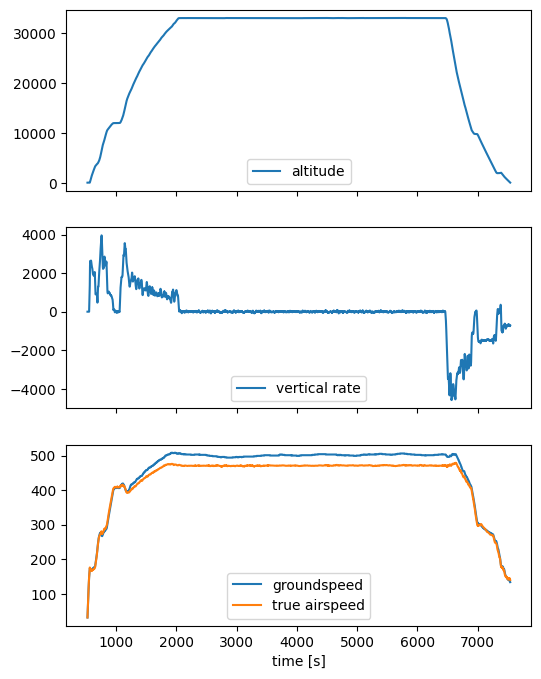

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

ax1.plot(flight.time, flight.altitude, label="altitude")
ax2.plot(flight.time, flight.vertical_rate, label="vertical rate")
ax3.plot(flight.time, flight.groundspeed, label="groundspeed")
ax3.plot(flight.time, flight.true_airspeed, label="true airspeed")
for ax in (ax1, ax2, ax3):
    ax.legend(loc="lower center")
ax3.set_xlabel("time [s]")
plt.show()

In [6]:
ff = openap.FuelFlow(ac="a320")

fuel_flow_estimate = ff.enroute(
    flight.mass, flight.true_airspeed, flight.altitude, flight.vertical_rate
)


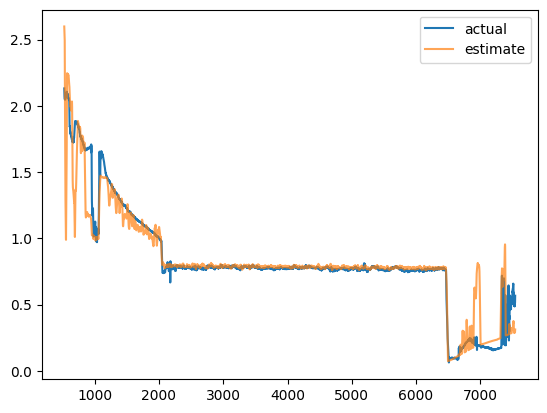

In [7]:
plt.plot(flight.time, flight.fuel_flow, label="actual")
plt.plot(flight.time, fuel_flow_estimate, label="estimate", alpha=0.7)
plt.legend()
plt.show()

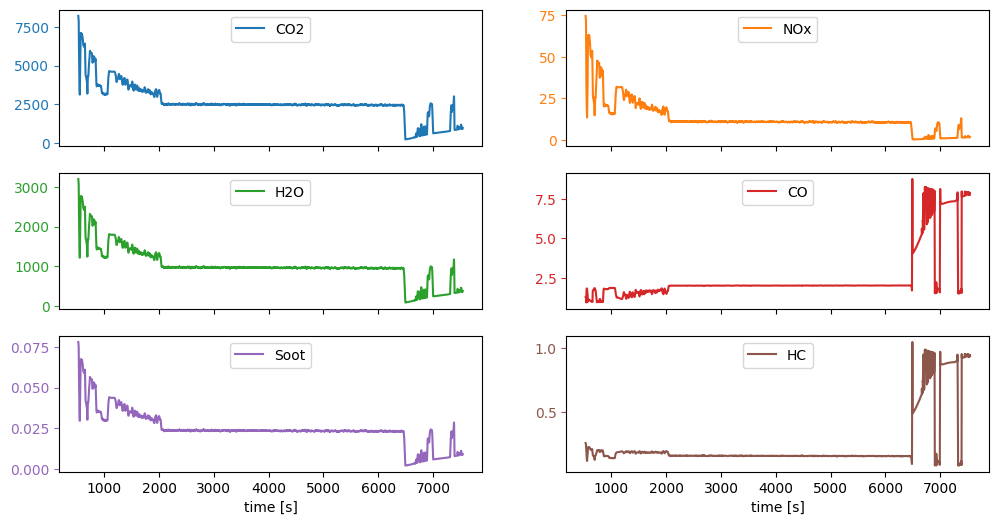

In [8]:
emi = openap.Emission(ac="a320")

co2 = emi.co2(fuel_flow_estimate)
h2o = emi.h2o(fuel_flow_estimate)
soot = emi.soot(fuel_flow_estimate)

nox = emi.nox(fuel_flow_estimate, flight.true_airspeed, flight.altitude)
co = emi.co(fuel_flow_estimate, flight.true_airspeed, flight.altitude)
hc = emi.hc(fuel_flow_estimate, flight.true_airspeed, flight.altitude)

fig, axes = plt.subplots(3, 2, figsize=(12, 6), sharex=True)

colors = plt.cm.tab10.colors
gases = [co2, nox, h2o, co, soot, hc]
labels = ["CO2", "NOx", "H2O", "CO", "Soot", "HC"]
for i, (gas, ax) in enumerate(zip(gases, axes.flat)):
    ax.plot(flight.time, gas, color=colors[i], label=labels[i])
    ax.legend(loc="upper center")
    ax.tick_params(axis="y", colors=colors[i])
for ax in axes[-1, :]:
    ax.set_xlabel("time [s]")


# Estimating fuel consumption from ADS-B data

In [9]:
flight = pd.read_csv(
    "https://github.com/junzis/tutorial-icrat24-openap/raw/master/data/hv5472_20240623.csv"
)

In [10]:
flight

,timestamp,utc,typecode,callsign,d_time,latitude,longitude,altitude,groundspeed,track,vertical_rate
0,1719124915,2024-06-23T06:41:55Z,B738,TRA57M,10.0,39.906254,4.228149,2050,206,10,1800.0
1,1719124925,2024-06-23T06:42:05Z,B738,TRA57M,10.0,39.915798,4.230225,2350,220,9,1800.0
2,1719124938,2024-06-23T06:42:18Z,B738,TRA57M,13.0,39.929996,4.233294,2825,239,9,2200.0
3,1719124951,2024-06-23T06:42:31Z,B738,TRA57M,13.0,39.944427,4.236415,3400,251,9,2700.0
4,1719124981,2024-06-23T06:43:01Z,B738,TRA57M,30.0,39.980896,4.244446,4950,271,9,3100.0
...,...,...,...,...,...,...,...,...,...,...,...
313,1719131969,2024-06-23T08:39:29Z,B738,TRA57M,9.0,52.385147,4.404221,2625,234,11,-1000.0
314,1719131978,2024-06-23T08:39:38Z,B738,TRA57M,9.0,52.394669,4.407425,2450,234,11,-1200.0
315,1719131984,2024-06-23T08:39:44Z,B738,TRA57M,6.0,52.400803,4.409561,2375,232,11,-800.0
316,1719131992,2024-06-23T08:39:52Z,B738,TRA57M,8.0,52.409821,4.412613,2225,232,11,-1100.0


/home/junzi/env/openap-v3/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


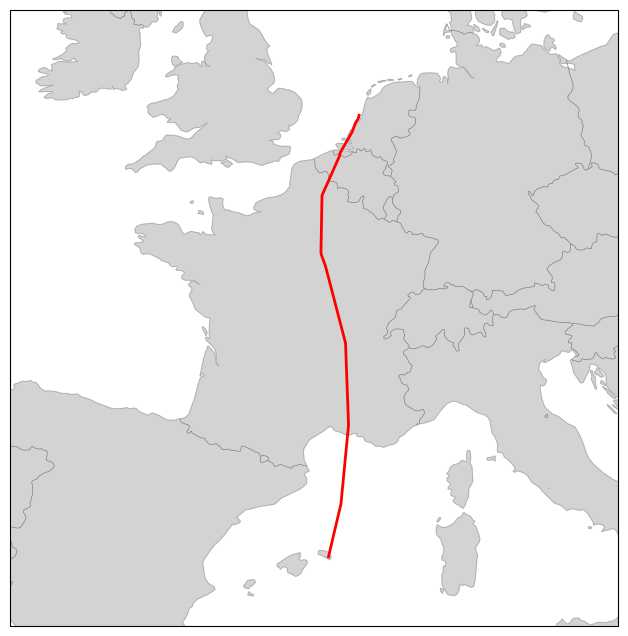

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={"projection": ccrs.EuroPP()})

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.COASTLINE, lw=0.5, color="darkgray")
ax.add_feature(cfeature.BORDERS, lw=0.5, color="gray")

ax.set_extent(
    [
        flight.longitude.min() - 10,
        flight.longitude.max() + 10,
        flight.latitude.min() - 2,
        flight.latitude.max() + 2,
    ]
)

ax.plot(flight.longitude, flight.latitude, transform=ccrs.Geodetic(), lw=2, color="red")
plt.show()

In [12]:
import openap.prop

aircraft = openap.prop.aircraft("B738")

ff = openap.FuelFlow(ac="B738")

mass_init = aircraft["mtow"] * 0.9

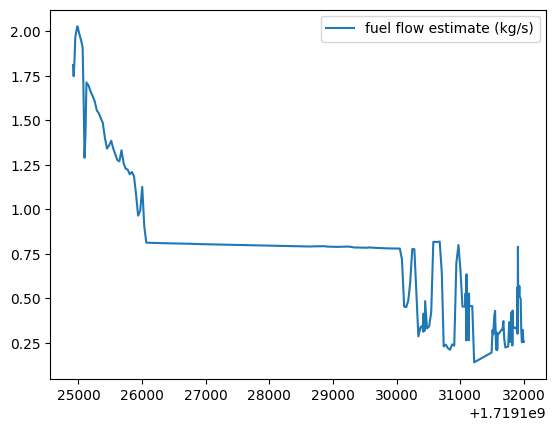

In [13]:
mass = mass_init
timestamp = flight.timestamp.iloc[0]

fuel_flow_estimate = []

for i, d in flight.iterrows():
    ffe = ff.enroute(mass=mass, tas=d.groundspeed, alt=d.altitude, vs=d.vertical_rate)
    mass -= ffe * d.d_time
    fuel_flow_estimate.append(ffe)


plt.plot(flight.timestamp, fuel_flow_estimate, label="fuel flow estimate (kg/s)")
plt.legend()
plt.show()